Exemplo baseado no artigo:
[RUNet: A robust UNet Architecture for Image Super-Resolution (CVPRW, 2019)](https://openaccess.thecvf.com/content_CVPRW_2019/papers/WiCV/Hu_RUNet_A_Robust_UNet_Architecture_for_Image_Super-Resolution_CVPRW_2019_paper.pdf)

Código construído com referência no github [Runet-Waifu-edition](https://github.com/franz96521/Runet-Waifu-edition/tree/main) - autor: [@franz96521](https://github.com/franz96521)


In [ ]:
!pip install torch-enhance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 16.0 MB/s eta 0:00:00


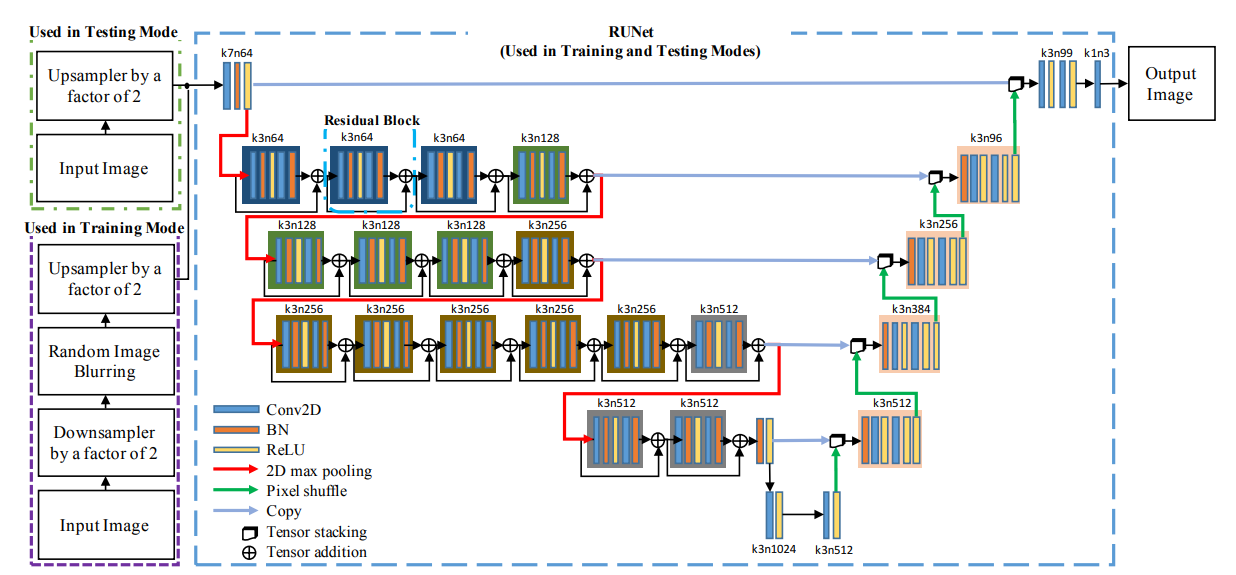

In [ ]:
import torch
import torch.nn as nn
import torch_enhance

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

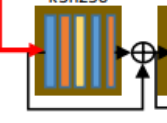

In [ ]:
# RUNet Down blocks

class Down(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=3,
               stride=1, padding="same", last_block=False):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                           stride=stride, padding=padding)
    self.bn1   = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                           stride=stride, padding=padding)
    self.bn2   = nn.BatchNorm2d(out_channels)

    if last_block:
      self.o = nn.Conv2d(in_channels, out_channels, 1, stride=1, padding="same")
    else:
      self.o = nn.Identity()

  def forward(self, x):

    x1 = self.conv1(x)
    x1 = self.bn1(x1)
    x1 = self.relu1(x1)
    x1 = self.conv2(x1)
    x1 = self.bn2(x1)

    return x1 + self.o(x)

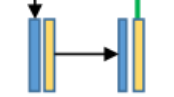

In [ ]:
# RUNet BottleNeck

class BottleNeck(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=3,
               stride=1, padding="same"):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                          stride=stride, padding=padding)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    return x

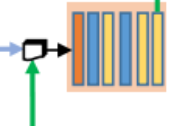

In [ ]:
# RUNet Up block

class Up(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3,
               stride=1, padding="same", shuffle=True):
    super().__init__()

    self.pixel_shuffle = nn.PixelShuffle(2) if shuffle else nn.Identity()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
    self.relu2 = nn.ReLU()
    self.relu3 = nn.ReLU()

  def forward(self, x, skip):
    x = self.pixel_shuffle(x)
    x = torch.cat([x, skip], dim=1)
    x = self.bn1(x)
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.relu3(x)
    return x

In [ ]:
class Final(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3,
               stride=1, padding="same", shuffle=True):
    super().__init__()

    # https://pytorch.org/docs/stable/generated/torch.nn.PixelShuffle.html
    self.pixel_shuffle = nn.PixelShuffle(2) if shuffle else nn.Identity()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
    self.relu2 = nn.ReLU()

  def forward(self, x, skip):
    x = self.pixel_shuffle(x)
    x = torch.cat([x, skip], dim=1)
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.relu2(x)

    return x

In [ ]:
class Runet(nn.Module):

  def __init__(self, **kwargs):
    super(Runet, self).__init__(**kwargs)

    self.c1 = nn.Sequential(
        nn.Conv2d(3,64,7,stride=1, padding="same"),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )

    self.mp1 = nn.MaxPool2d((2, 2))

    self.down1 = nn.Sequential(
        Down(64, 64), Down(64, 64),
        Down(64, 64), Down(64, 128, last_block=True),
    )

    self.mp2 = nn.MaxPool2d((2, 2))

    self.down2 = nn.Sequential(
        Down(128, 128), Down(128, 128),
        Down(128, 128), Down(128, 256, last_block=True),
    )

    self.mp3 = nn.MaxPool2d((2, 2))

    self.down3 = nn.Sequential(
        Down(256, 256), Down(256, 256),
        Down(256, 256), Down(256, 256),
        Down(256, 256), Down(256, 512, last_block=True),
    )

    self.mp4 = nn.MaxPool2d((2, 2))

    self.down4 = nn.Sequential(
        Down(512, 512), Down(512, 512),
        nn.BatchNorm2d(512), nn.ReLU()
    )

    self.bottleneck = nn.Sequential(
        BottleNeck(512, 1024),
        BottleNeck(1024, 512)
    )

    self.up1 = Up(1024, 512, shuffle=False)
    self.up2 = Up(640, 384, shuffle=True)
    self.up3 = Up(352, 256, shuffle=True)
    self.up4 = Up(192, 96, shuffle=True)

    self.final  = Final(88, 99, shuffle=True)
    self.c2     = nn.Conv2d(99,3,1,stride=1,padding="same")

  def forward(self, x):

    x1 = self.c1(x)

    x2 = self.down1(self.mp1(x1))
    x3 = self.down2(self.mp2(x2))
    x4 = self.down3(self.mp3(x3))
    x5 = self.down4(self.mp4(x4))

    x6 = self.bottleneck(x5)

    x7 = self.up1(x6,x5)
    x8 = self.up2(x7,x4)
    x9 = self.up3(x8,x3)
    x10 = self.up4(x9,x2)

    x11 = self.final(x10,x1)
    x12 = self.c2(x11)
    return x12





In [ ]:
input = torch.rand((1,3,224,224))

net = Runet()

net.to(DEVICE)

output = net(input.to(DEVICE))

print(output.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
#loss = torch_enhance.losses.VGG()
from torch_enhance import metrics

loss = nn.MSELoss(reduction='mean')

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
from torch_enhance.datasets import BSDS300, Set14, Set5
from torch.utils.data import DataLoader

train_dataset = DataLoader(BSDS300(2), batch_size=32)
valid_dataset = DataLoader(Set14(2),   batch_size=1)
test_dataset  = DataLoader(Set5(2),    batch_size=1)

100%|██████████| 22211847/22211847 [00:08<00:00, 2533417.29it/s]


Extracting /content/.data/BSDS300-images.tgz to /content/.data


5096261it [00:00, 52893106.28it/s]
852383it [00:00, 113009022.20it/s]


In [ ]:
from torch_enhance import metrics
import torch.nn.functional as F

from torchvision import transforms

input_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Resize((128,128)),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

target_transform = transforms.Compose([
    transforms.Resize((128,128)),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

epochs = 100

for e in range(epochs):

  print(f'Epoch: {e}')

  net.train()
  for i, (sample, target) in enumerate(train_dataset):
    sample = sample.to(DEVICE)
    target = target.to(DEVICE)
    sample = input_transform(sample)
    target = target_transform(target)
    optimizer.zero_grad()
    output = net(sample)
    error  = loss(output, target)
    error.backward()
    optimizer.step()

    mae = metrics.mae(output, target)
    psnr = metrics.psnr(output, target)

    print(f"Step ({i}): Loss: {error}; MAE: {mae}; PSNR: {psnr}")

  net.eval()
  for i, (sample, target) in enumerate(valid_dataset):
    sample = sample.to(DEVICE)
    target = target.to(DEVICE)
    sample = input_transform(sample)
    target = target_transform(target)

    output = net(sample)

    mae = metrics.mae(output, target)
    psnr = metrics.psnr(output, target)

    print(f"Validation step ({i}): MAE: {mae}; PSNR: {psnr}")


Epoch: 0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step (0): Loss: 0.2805868089199066; MAE: 0.45874568819999695; PSNR: 5.519327640533447
Step (1): Loss: 0.07453498989343643; MAE: 0.22642207145690918; PSNR: 11.276397705078125
Step (2): Loss: 0.2634159028530121; MAE: 0.3732110857963562; PSNR: 5.793580532073975
Step (3): Loss: 0.039614684879779816; MAE: 0.16707676649093628; PSNR: 14.021438598632812
Step (4): Loss: 0.07638988643884659; MAE: 0.2392461597919464; PSNR: 11.169641494750977
Step (5): Loss: 0.08148188889026642; MAE: 0.24557366967201233; PSNR: 10.889389038085938
Step (6): Loss: 0.09595613181591034; MAE: 0.2505621016025543; PSNR: 10.179272651672363
Validation step (0): MAE: 0.368985652923584; PSNR: 7.194911003112793
Validation step (1): MAE: 0.3072587847709656; PSNR: 8.710077285766602
Validation step (2): MAE: 0.4428635537624359; PSNR: 6.0013580322265625
Validation step (3): MAE: 0.3185168504714966; PSNR: 8.031817436218262
Validation step (4): MAE: 0.3278793692588806; PSNR: 8.282343864440918
Validation step (5): MAE: 0.474726051092

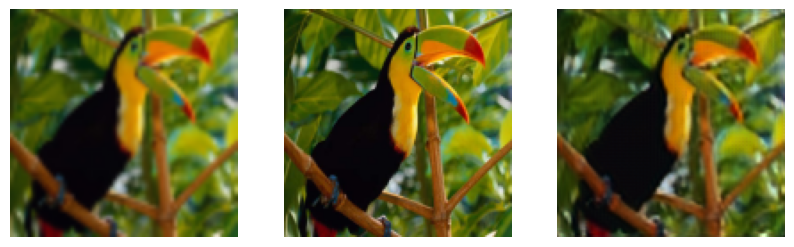

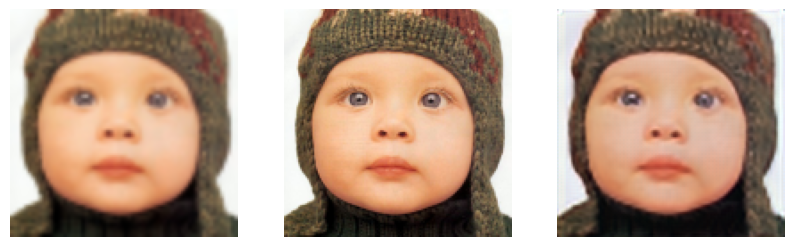

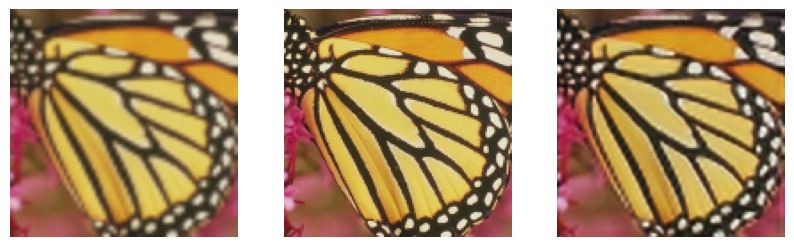

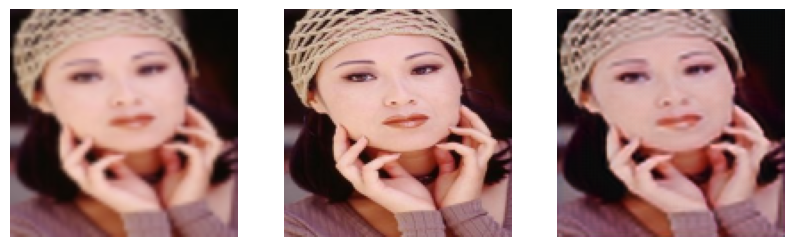

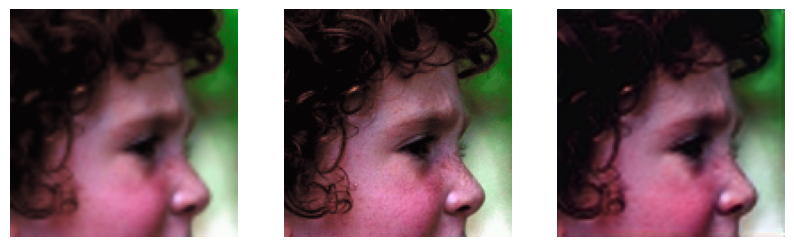

In [ ]:
#sample, target = next(iter(test_dataset))

#print(sample)

for sample, target in test_dataset:

    sample = input_transform(sample)
    target = target_transform(target)

    #print(sample)

    from matplotlib import pyplot as plt
    import numpy

    fig = plt.figure(figsize=(10, 7))
    rows = 1
    columns = 3

    npimg1 = numpy.squeeze(sample.permute(0, 2, 3, 1).numpy(), axis=0)

    npimg2 = numpy.squeeze(target.permute(0, 2, 3, 1).numpy(), axis=0)

    output = net(sample.to(DEVICE))
    npimg3 = numpy.squeeze(output.permute(0, 2, 3, 1).cpu().detach().numpy(), axis=0)


    fig.add_subplot(rows, columns, 1)
    plt.imshow(npimg1)
    plt.axis('off')
    fig.add_subplot(rows, columns, 2)
    plt.imshow(npimg2)
    plt.axis('off')
    fig.add_subplot(rows, columns, 3)
    plt.imshow(npimg3)
    plt.axis('off')


